בס"ד

ב"ה

**M11 Practical Challenge: Decision Tree versus Random Forest Performance**

Ben Besthof, Tal Benhamou, Daniel Malinsky

DAV 6150

03/27/2024

**Introduction**

Objective of this assignment is to discover if decision trees or random forests best classifies a school's range of awarded regents diplomas. Two sets of models will be built using different purity measures: gini index and entropy measure. 

Feature selection will be based on correlation thresholds. If two features, for example, have a positive or negative correlation of 0.8 then the features will be considered for removal. The goal of feature selection is to reduce computational strain. 

In [25]:
#import required packages
!pip install regex
!pip install imblearn

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import sklearn 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTENC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

df = pd.read_csv('M11_Data.csv')

df

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658,464,71%,310,47%,148,22%
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324,246,76%,169,52%,65,20%
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334,218,65%,141,42%,83,25%
3,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,4,American Indian/Alaska Native,-,-,-,-,-,-,-
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367,248,68%,183,50%,91,25%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73147,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,18,Not Migrant,-,-,-,-,-,-,-
73148,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,20,Homeless,-,-,-,-,-,-,-
73149,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,21,Not Homeless,-,-,-,-,-,-,-
73150,2018-19,3,District,DUNDEE CENTRAL SCHOOL DISTRICT,4,Rural High Needs,68,YATES,0,2013 Total Cohort - 6 Year Outcome - August 2019,23,Not in Foster Care,-,-,-,-,-,-,-


**General Information of Data Set**

Checking data types, null count, columns and rows.

In [26]:
general = df.info()
general

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73152 entries, 0 to 73151
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   report_school_year  73152 non-null  object
 1   aggregation_index   73152 non-null  int64 
 2   aggregation_type    73152 non-null  object
 3   aggregation_name    73152 non-null  object
 4   nrc_code            73152 non-null  int64 
 5   nrc_desc            73152 non-null  object
 6   county_code         73152 non-null  int64 
 7   county_name         73152 non-null  object
 8   nyc_ind             73152 non-null  int64 
 9   membership_desc     73152 non-null  object
 10  subgroup_code       73152 non-null  int64 
 11  subgroup_name       73152 non-null  object
 12  enroll_cnt          73152 non-null  object
 13  grad_cnt            73152 non-null  object
 14  grad_pct            73152 non-null  object
 15  reg_cnt             73152 non-null  object
 16  reg_pct             73

Majority of variables are discrete numerical outcomes. And within the numerical variables most of them are count or percentage data. It is important to note that percentages and counts are being read as objects rather than floats and integers. The counts and rates variables need to be converted to numerical features so that models can interpret the data appropriately.

In [27]:
# List of variables to convert
convert_var = ['enroll_cnt',
 'grad_cnt',
 'grad_pct',
 'reg_cnt',
 'reg_pct',
 'dropout_cnt',
 'dropout_pct']


Duplicates Check

In [28]:

#creating object that sums duplicates
duplicated = df.duplicated().sum()

print('sum of duplicates', duplicated)

sum of duplicates 0


**Creating the target variable**


The target will be a categorical indicator variable derived from the dataset’s reg_pct attribute. This new
indicator variable will be comprised of three possible values:

A. “low”: indicates that the percentage of regents diplomas awarded for a given school district /
student subgrouping is less than ½ of the median percentage of all regent diplomas awarded (i.e.,
across all school district / student subgroupings);

B. “medium”: indicates that the percentage of regents diplomas awarded for a given school district /
student subgrouping is between 0.5 * the median percentage of all regent diplomas awarded (i.e.,
across all school district / student subgroupings) and 1.5 * the median percentage of all regent
diplomas awarded (i.e., across all school district / student subgroupings), i.e., (0.5 * median
percentage) < percentage of regents diplomas awarded for a given school district <= (1.5 * median
percentage)

C. “high”: indicates that the percentage of regents diplomas awarded for a given school district /
student subgrouping exceeds 1.5 * the median percentage of all regent diplomas awarded (i.e.,
across all school district / student subgroupings).

Values in all percentage columns need to be transformed into floats rather than keeping them as string values. Not only is this being done to help the models correctly interpret the data, but it will also help create the new variable. Regular expressions will be used to remove the percent character from all percentage columns and after the variables will be converted from string to float. 


In [29]:
#checking value counts in regents percentage column to inspect additional string characters.
df['reg_pct'].value_counts()

reg_pct
-      33478
50%     1528
44%     1210
40%     1190
43%     1189
       ...  
84%       25
87%       25
2%        15
3%        13
1%         4
Name: count, Length: 102, dtype: int64

Almost half of all records in the dataset contain value '-' which can be assumed to indicate a null value. In other words a significant proportion of instances contain missing values across numerical variables. 

In [30]:
#creating a function that removes % characters, converts percentages from strings to floats, drops nulls, and creates target variable

def cleaning(df, columns):
    """removes % characters, converts percentages from strings to floats, converts counts to integers 

        Args:
            df : dataframe to be used
            columns: list of columns that need cleaning

        Returns: dataframe with no strings in percentage and count data    
    """
    #creating groups of variables: percentages and counts
    percentages = [i for i in columns if 'pct' in i]
    counts = [i for i in columns if i not in percentages]
    
    def fixing(dfcolumn):
        """ takes percentage characters out of percentage values

        Args:
            df : dataframe containing variables that need fixing 
        
        Returns: dataframe with clean values 
        """
        pattern = re.compile('%')
        clean = pattern.sub('', str(dfcolumn))
        return clean

    #need to apply fixing function to every percentage manually because df[percentages] has a list data type and the .astype() or .to_numeric() function will not apply to a list
    for i in percentages:
        df[i] = df[i].apply(fixing)
        df[i] = pd.to_numeric(df[i], errors = 'coerce')
        df.dropna(inplace = True)
        df.reset_index()
        df[i] = df[i]/100
    
    for i in counts:
        df[i] = pd.to_numeric(df[i], errors='coerce')
        df.dropna(inplace = True)
        df[i] = df[i].astype(int)
    
    #creating target variable
    df['reg_awd'] = df['reg_pct'].apply(lambda x: 2 if x > (1.5 * df['reg_pct'].median()) else(1 if x <= (1.5 * df['reg_pct'].median()) and x >= (0.5 * df['reg_pct'].median()) else 0))


    return df

df = cleaning(df, convert_var) 

df.head()

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct,reg_awd
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658,464,0.71,310,0.47,148,0.22,1
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324,246,0.76,169,0.52,65,0.20,1
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334,218,0.65,141,0.42,83,0.25,1
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367,248,0.68,183,0.50,91,0.25,1
5,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,6,Hispanic,98,58,0.59,40,0.41,28,0.29,1


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39674 entries, 0 to 73146
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   report_school_year  39674 non-null  object 
 1   aggregation_index   39674 non-null  int64  
 2   aggregation_type    39674 non-null  object 
 3   aggregation_name    39674 non-null  object 
 4   nrc_code            39674 non-null  int64  
 5   nrc_desc            39674 non-null  object 
 6   county_code         39674 non-null  int64  
 7   county_name         39674 non-null  object 
 8   nyc_ind             39674 non-null  int64  
 9   membership_desc     39674 non-null  object 
 10  subgroup_code       39674 non-null  int64  
 11  subgroup_name       39674 non-null  object 
 12  enroll_cnt          39674 non-null  int64  
 13  grad_cnt            39674 non-null  int64  
 14  grad_pct            39674 non-null  float64
 15  reg_cnt             39674 non-null  int64  
 16  reg_pct  

In [32]:
len(df['report_school_year'].value_counts().index)

1

**Exploratory Data Analysis**

In [33]:
def preprocessor(df, target):
  """
  Preparing data for model training

  Args:
    df: dataset to be analyzed
    target(str): column name of target variable


  Returns:
    A DataFrame with:
     -target values transformed
     -numerical values standardized
     -balanced target variable distribution
     
"""

  categorical_variables = list(df.select_dtypes(include = object))
  categorical_variables = list(set(categorical_variables) - set(target))
  numerical_variables = list(df.select_dtypes(exclude = object))
  numerical_variables = list(set(numerical_variables) - set(target))
  #gathering variables with zero variance
  no_var = []
  for i in numerical_variables:
      if df[i].std() == 0.0:
          no_var.append(i)

  numerical_variables = list(set(numerical_variables) - set(no_var))

  #categorical variables with too much variance 
  high_card = []
  for i in categorical_variables:
    if len(df[i].value_counts().index) > 200:
       high_card.append(i)

  #categorical variables with zero variance 
  low_card = []
  for i in categorical_variables:
     if len(df[i].value_counts().index) == 1:
        low_card.append(i)


#dropping features with zero variance and high cardinality 
  df.drop(no_var, axis = 1, inplace = True)
  df.drop(high_card, axis = 1, inplace = True)
  df.drop(low_card, axis = 1, inplace = True)



#balancing target variable with oversampling
  def oversampler(df, target):
    categorical_variables = list(df.select_dtypes(include = object))
    categorical_variables = list(set(categorical_variables) - set(target))
    oversamp = SMOTENC(categorical_features = categorical_variables, random_state = 42)
    input_var = list(df.columns)
    input_var.remove(target)
    X, y = oversamp.fit_resample(df[input_var], df[target])
    X = pd.DataFrame(X, columns = input_var)
    y = pd.DataFrame(y, columns = [i for i in df.columns if i == target])
    df = pd.concat([X, y], axis = 1)
    return df

  df = oversampler(df, target)

  return df

#creating a copy of the dataset to compare the effects of preprocessing
df_copy = preprocessor(df.copy(), 'reg_awd')
df_copy.head()

,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct,reg_awd
0,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658,464,0.71,310,0.47,148,0.22,1
1,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324,246,0.76,169,0.52,65,0.20,1
2,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334,218,0.65,141,0.42,83,0.25,1
3,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367,248,0.68,183,0.50,91,0.25,1
4,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,6,Hispanic,98,58,0.59,40,0.41,28,0.29,1


In [34]:
df.head()

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,grad_cnt,grad_pct,reg_cnt,reg_pct,dropout_cnt,dropout_pct,reg_awd
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658,464,0.71,310,0.47,148,0.22,1
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324,246,0.76,169,0.52,65,0.20,1
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334,218,0.65,141,0.42,83,0.25,1
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367,248,0.68,183,0.50,91,0.25,1
5,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,6,Hispanic,98,58,0.59,40,0.41,28,0.29,1


Target Variable 

Distribution of values before and after preprocessing 

In [39]:
before = df['reg_awd'].value_counts()
after = df_copy['reg_awd'].value_counts()

print('Target value distribution of classes:', '\n', before)
print('\n')
print('Target value distribution of classes after preprocessing:', '\n', after)

Target value distribution of classes: 
 reg_awd
1    32258
0     3915
2     3501
Name: count, dtype: int64


Target value distribution of classes after preprocessing: 
 reg_awd
1    32258
0    32258
2    32258
Name: count, dtype: int64


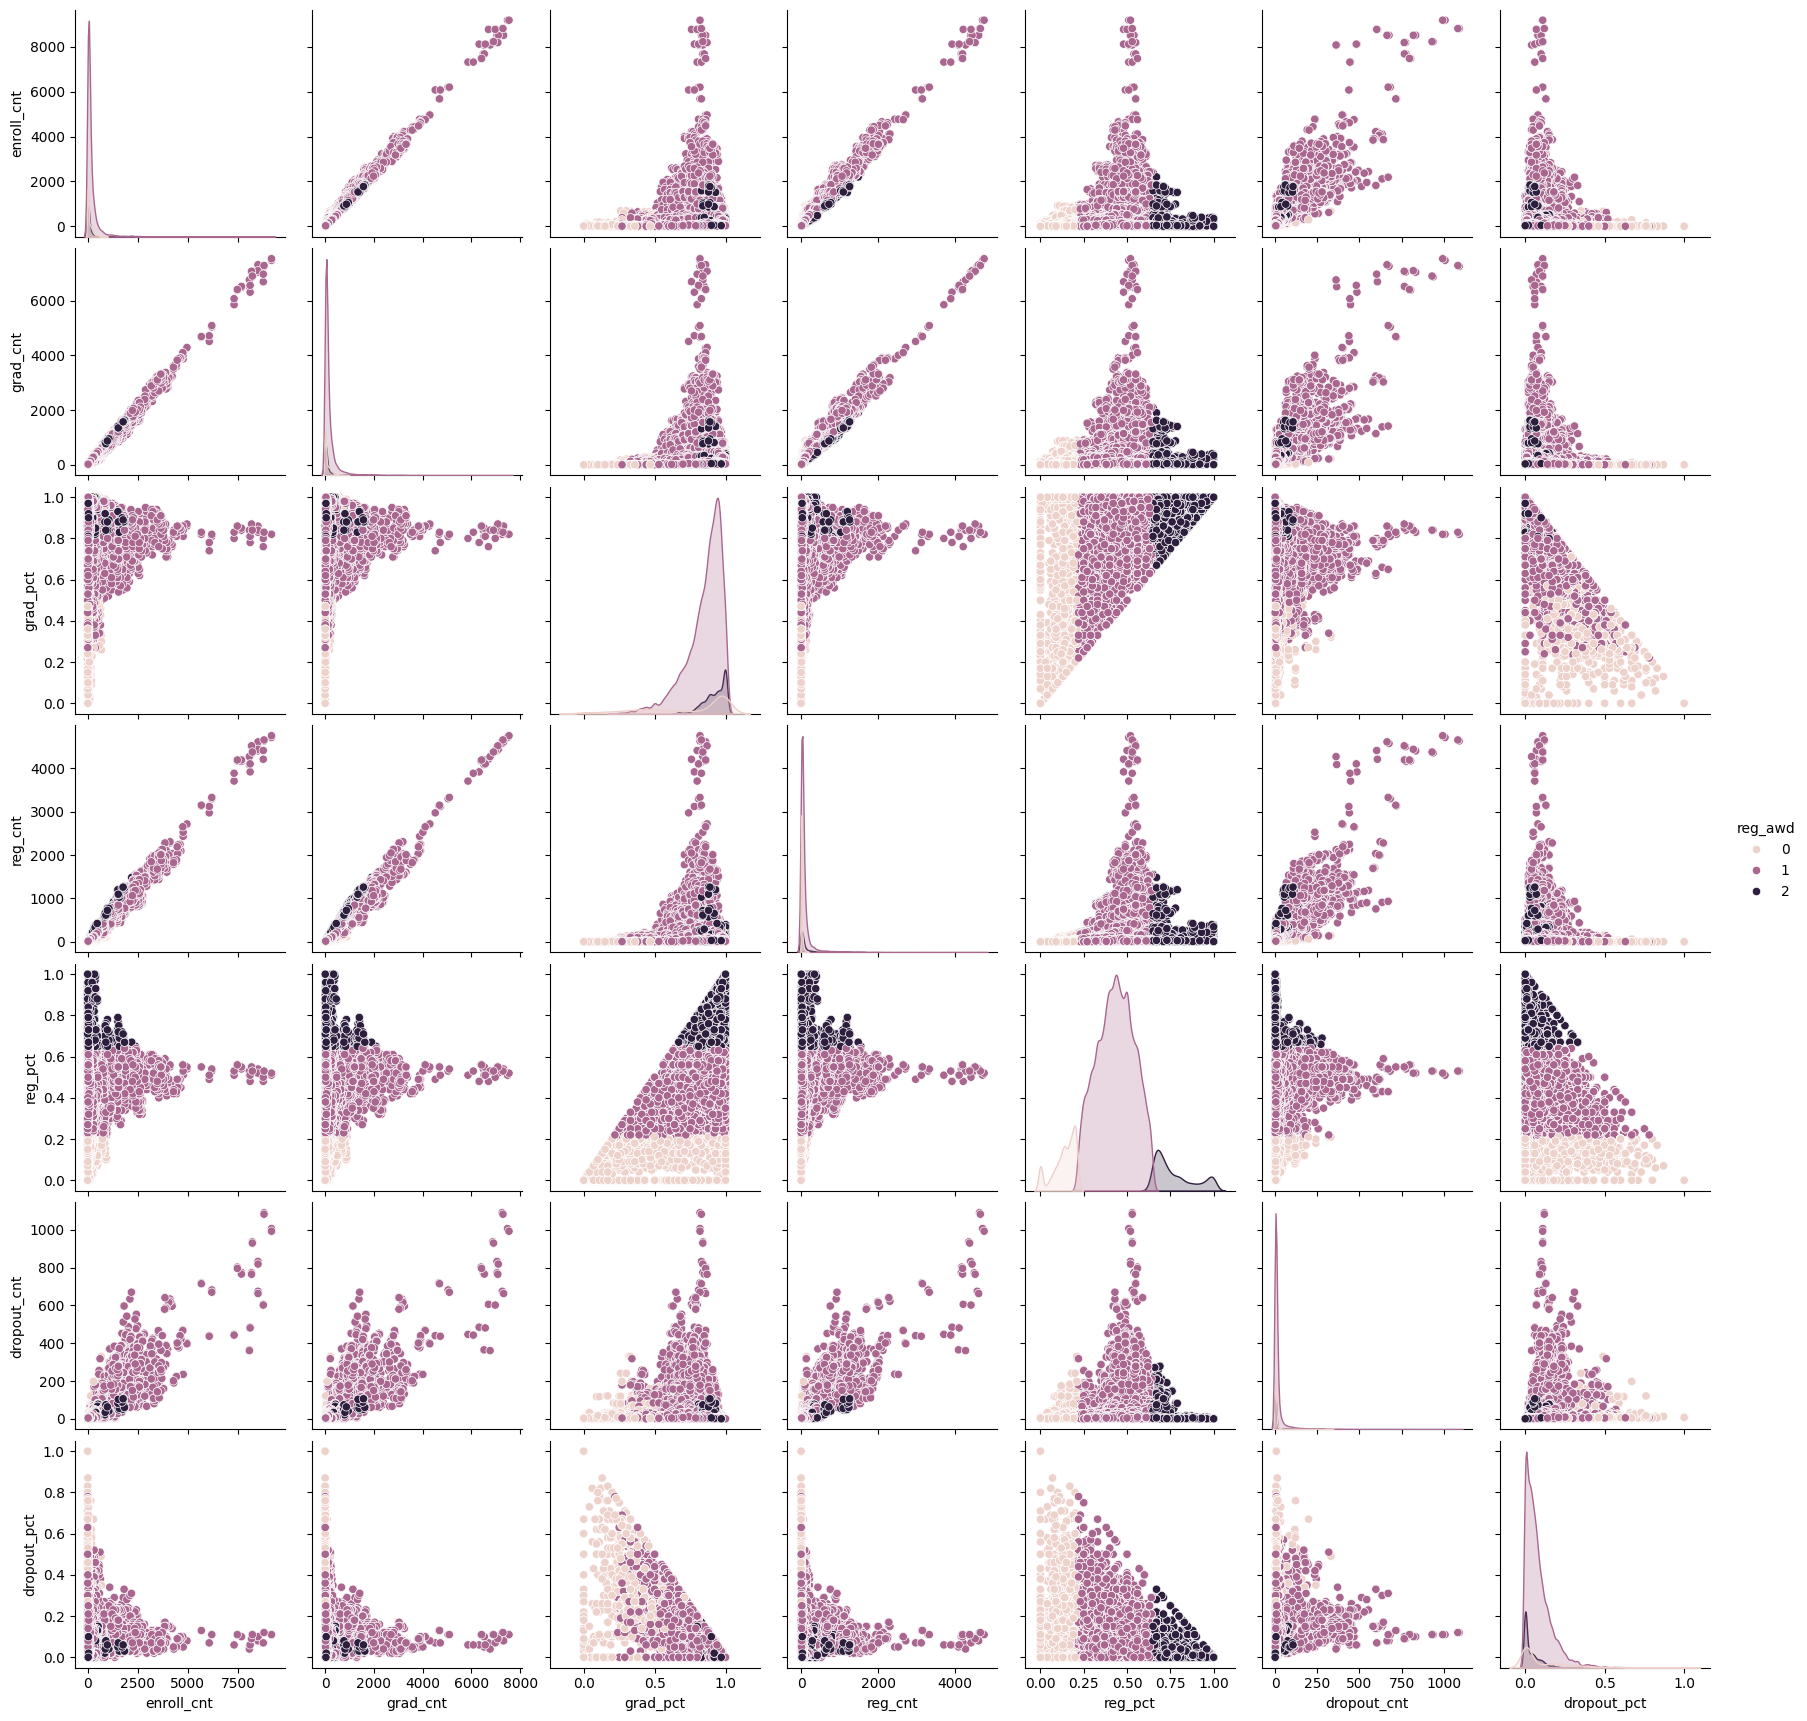

In [41]:
predictors = [ 'enroll_cnt',
 'grad_cnt',
 'grad_pct',
 'reg_cnt',
 'reg_pct',
 'dropout_cnt',
 'dropout_pct',
 'reg_awd']
sns.pairplot(df[predictors], hue = 'reg_awd')

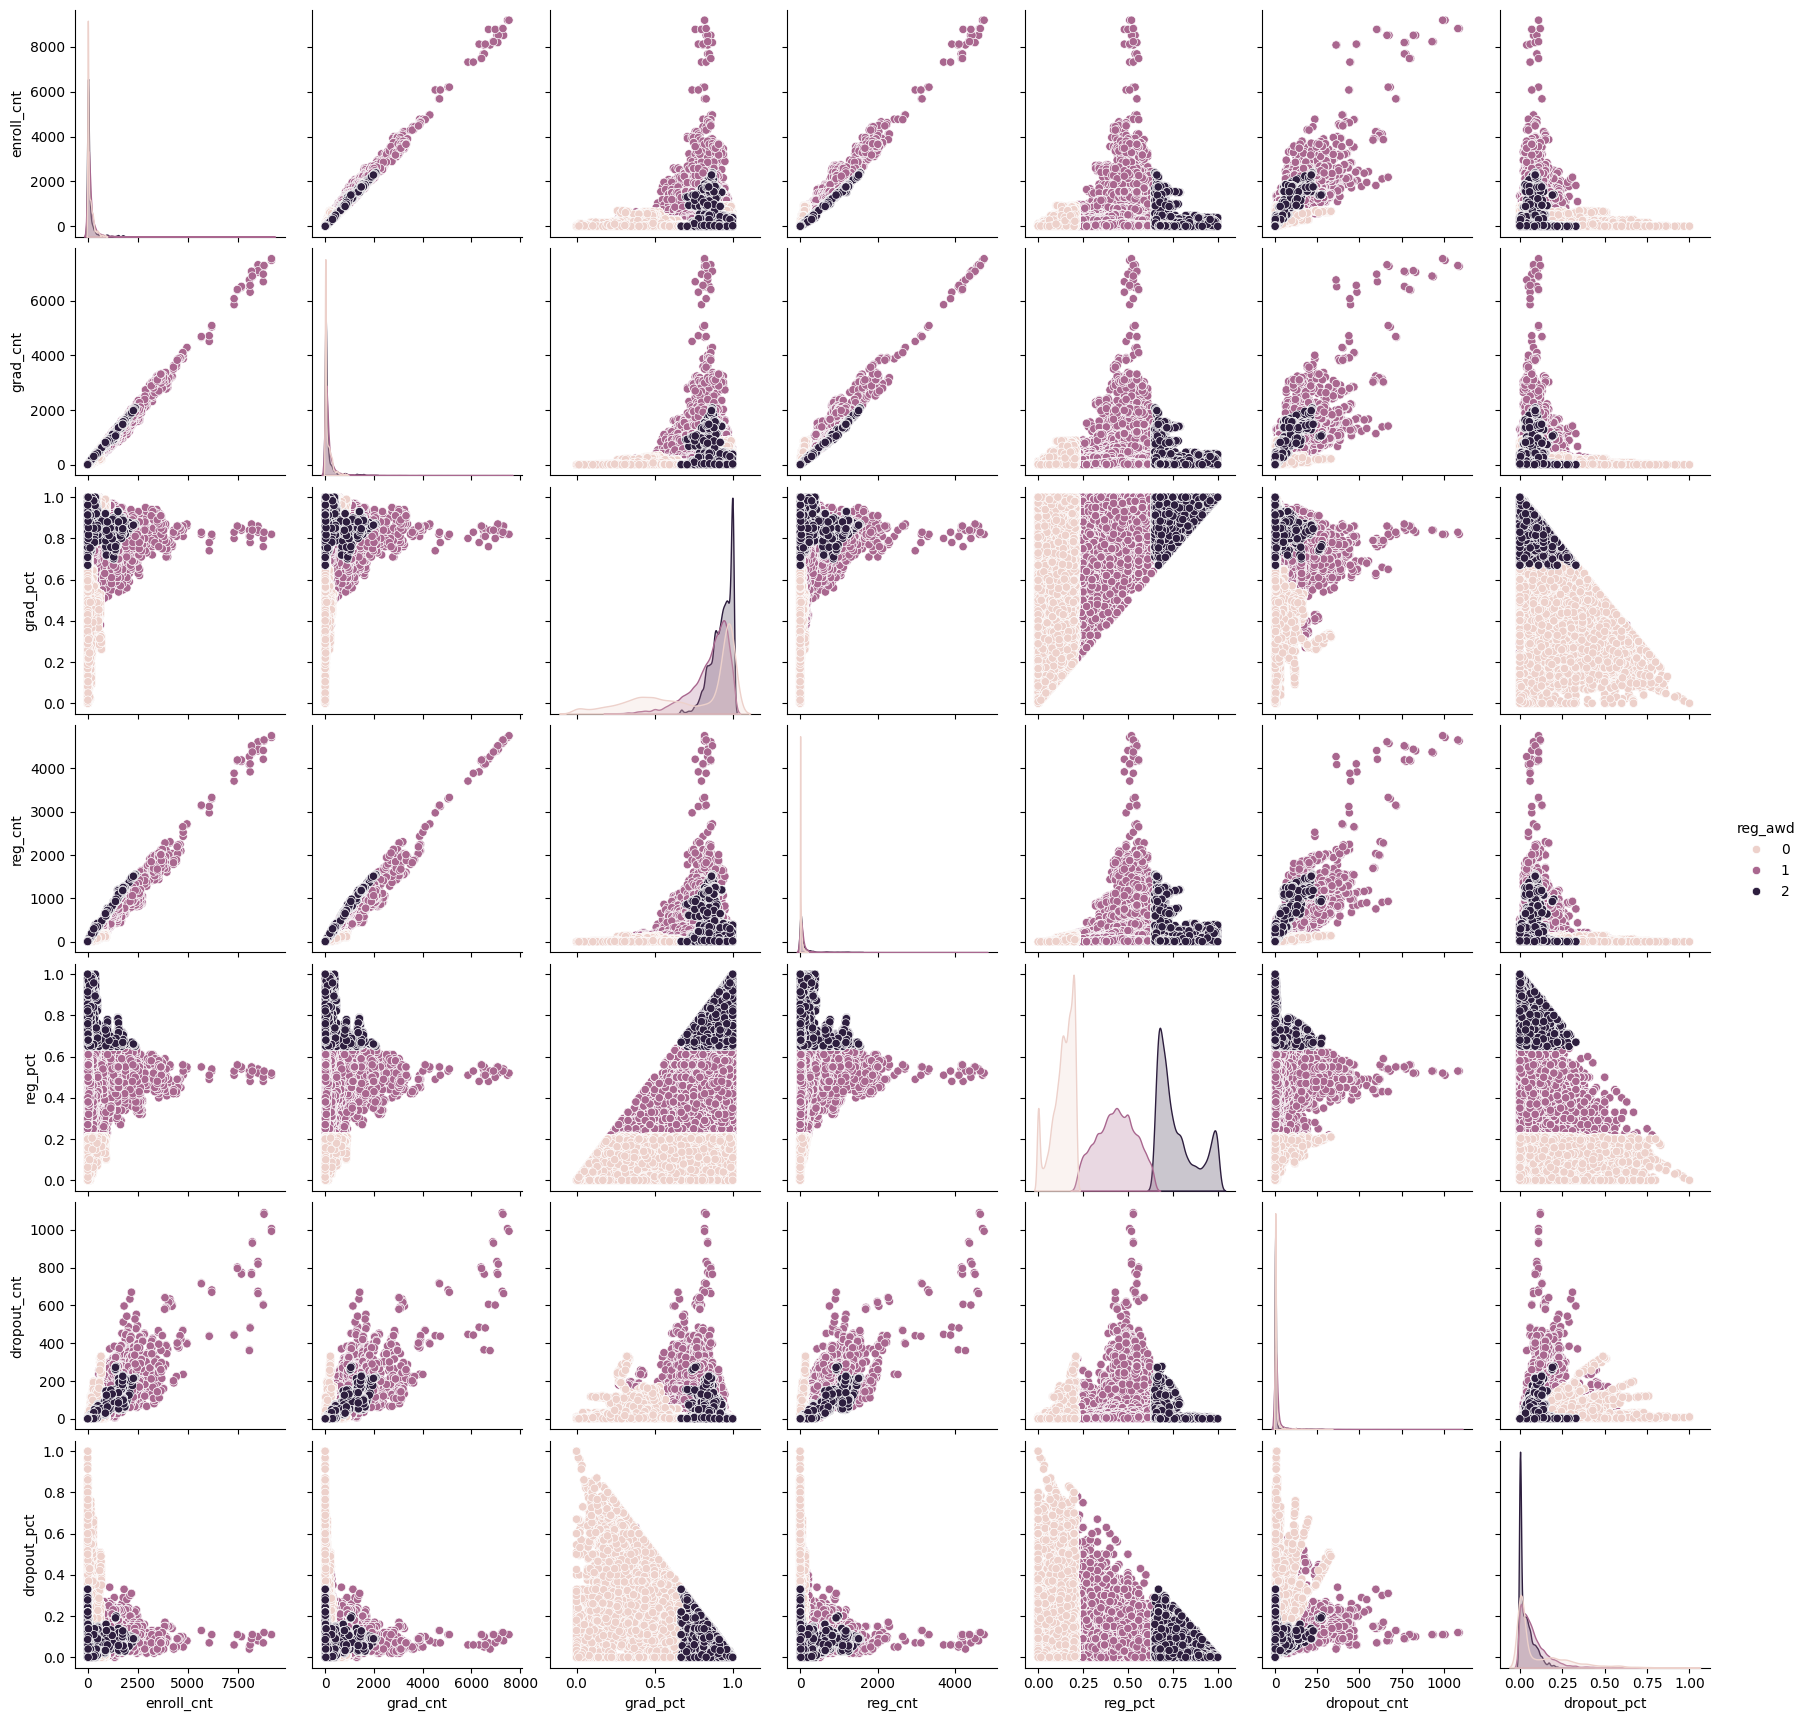

In [42]:
sns.pairplot(df_copy[predictors], hue = 'reg_awd')

**Data Preparation**

**Model Building**

**Model Selection**

**Conclusions**